In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv , os ,  tqdm , time , ssm , json
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pathlib import Path
from plotly import tools
from matplotlib import cm
from ARHMM_utils import *
from DataSnipper import DataSnipper
from sklearn.model_selection import train_test_split
from ARHMM_wo_test import fit_ARHMM,make_similarity_matrix,merge_two_states
import pickle
from ARHMM_plots import make_cross_likelihood_matrix
from ssm.plots import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [5]:
data_frame2 = pd.read_csv("mouse_2050/new_20201120_behaviour2020_v_2050_for_frans_1_pose_data.csv")#[70444:78244]
#data_frame2 = pd.read_csv("mouse_2053/new_20201120_behaviour2020_v_2053_for_frans_1_pose_data.csv")#[70444:78244]
#data_frame2 = pd.read_csv("mouse/20201202_behaviour2020_v_6287_distractionduring_task_vol2_1_pose_data.csv")#[10000:230000]
#data_frame3 = pd.read.csv("")
data = data_frame2.to_numpy()
print(data.shape)
interval_start = 0
interval_end = 220000

div = 10

ARHMM_kwargs={  'kappa':2500,
                'use_best_K':True, 
                'K':11,
                'epochs':50,
                'start_K':1,
                'end_K':30}
threshold = 0.01

make_vid = True
smooth = True
box_size = 0.6
box_pixel = 400
T = 2e-3
d = 5
seed = 1337
early_stopping = True

#timestr = time.strftime("%Y%m%d-%H%M%S")
#p = os.path.normpath(data_csv)
#newpath = os.sep.join([os.sep.join(p.split(os.sep)[:-1]), 'results',timestr])

#Path(newpath).mkdir(parents=True, exist_ok=True)

kappa = ARHMM_kwargs['kappa']


#data_frame2 = pd.read_csv(data_csv)

if interval_end in ['end',-1]:
    interval_end = len(data_frame2) - 1

interval = range(interval_start,interval_end)

# Preprocess data
data_to_use , df , speed , head_body_angle , body_len , outliers = preprocess_data(data_frame2, interval, div, smooth, box_size, box_pixel, d, T)

interval = np.linspace(interval_start + d,interval_end-len(outliers),len(speed))

(260879, 11)
Number of outliers removed: 285 (0.012954545454545455 %)


/Users/corytrevor/Documents/Skola/KTH/EE/Master/DD2430 projekt i maskininlärning/KI2020/Analysis/ARHMM_utils.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/corytrevor/Documents/Skola/KTH/EE/Master/DD2430 projekt i maskininlärning/KI2020/Analysis/ARHMM_utils.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



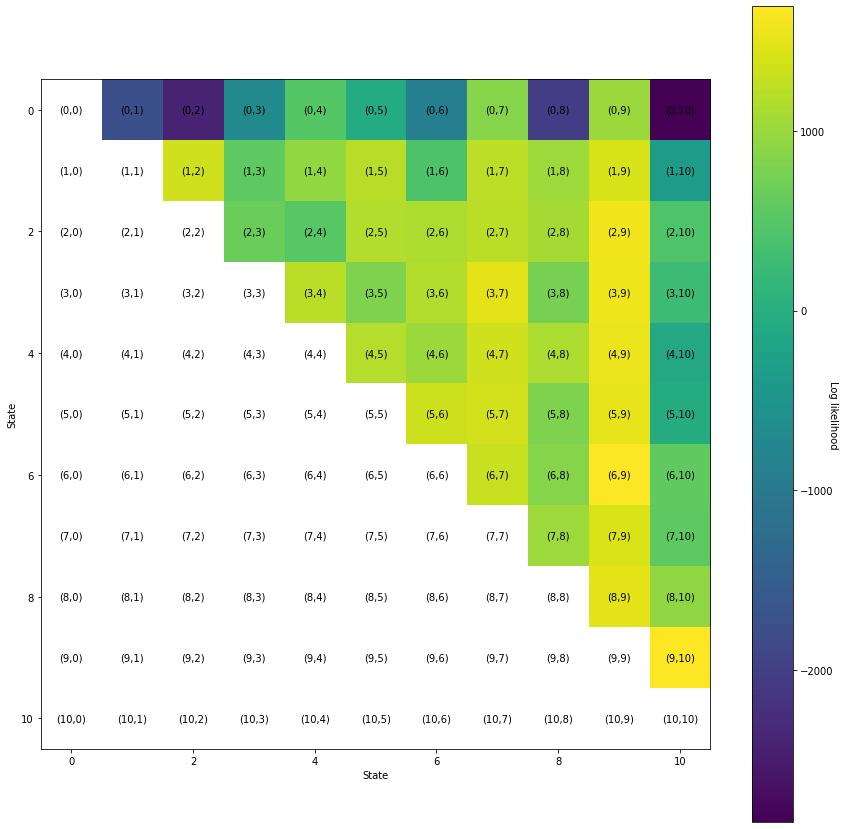

In [32]:

hmm = pickle.load(open("hmm_model_11_states_2500_kappa.p", "rb" ))
hmm_z = hmm.most_likely_states(data_to_use,)



fig2 , ax = plt.subplots(1,1,figsize=(15,15))
similarity, new_hmms = make_similarity_matrix(hmm, data_to_use)
#im = plt.imshow(similarity)
#plt.ylabel("state 1")
#plt.xlabel("state 2")
#plt.title("similarity")


im = ax.imshow(similarity)
cbar = fig2.colorbar(im,ax=ax)
#ax.set_title('Cross-Likelihoods')
ax.set_ylabel('State')
ax.set_xlabel('State')
cbar.ax.set_ylabel('Log likelihood', rotation=270)
for (j, i), _ in np.ndenumerate(similarity):
    label = '({},{})'.format(j, i)
    plt.text(i,j,label,ha='center',va='center')
#plt.show()
fig2.savefig("merge_before_2050_kappa2500.png")


In [39]:
print(new_hmms.shape)

(11, 11)


In [40]:
merged_hmm = new_hmms[6,9]
print(merged_hmm.K)
print(merged_hmm.log_probability(data_to_use)/data_to_use.shape[0])
print(hmm.log_probability(data_to_use)/data_to_use.shape[0])

10
9.797043603855881
9.720717049423516


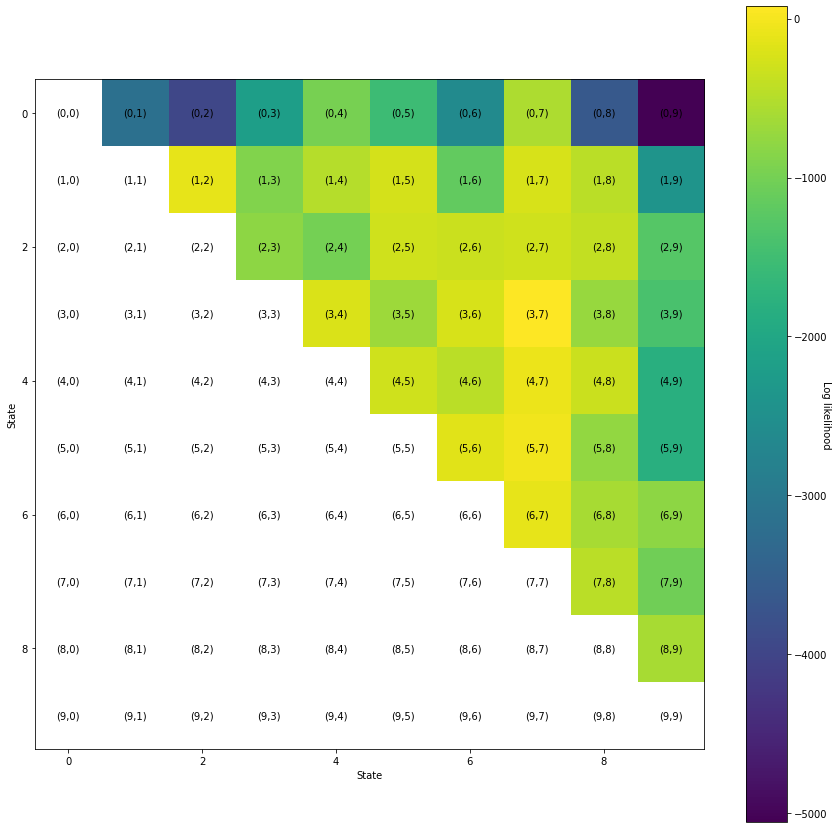

In [41]:
fig2 , ax = plt.subplots(1,1,figsize=(15,15))
similarity, new_hmms_2 = make_similarity_matrix(merged_hmm, data_to_use)
#im = plt.imshow(similarity)
#plt.ylabel("state 1")
#plt.xlabel("state 2")
#plt.title("similarity")


im = ax.imshow(similarity)
cbar = fig2.colorbar(im,ax=ax)
#ax.set_title('Cross-Likelihoods')
ax.set_ylabel('State')
ax.set_xlabel('State')
cbar.ax.set_ylabel('Log likelihood', rotation=270)
for (j, i), _ in np.ndenumerate(similarity):
    label = '({},{})'.format(j, i)
    plt.text(i,j,label,ha='center',va='center')
#plt.show()
fig2.savefig("merge_after_2050_kappa2500.png")

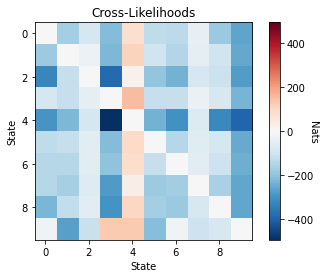

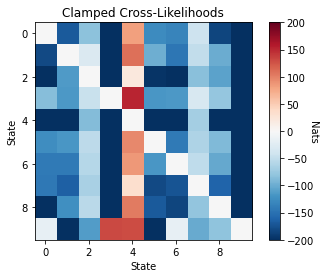

In [31]:
hmm_z = merged_hmm.most_likely_states(data_to_use,)
df = pd.DataFrame(data_to_use,columns=['speed','yaw','bl'])
df['state'] = hmm_z
#print(df['state'][0:60])
make_cross_likelihood_matrix(merged_hmm,df,"cll.png")

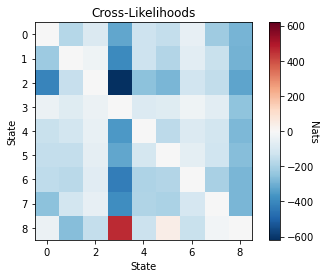

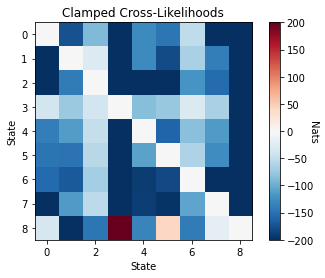

In [34]:
hmm_3 = new_hmms_2[3,4]
hmm_z = hmm_3.most_likely_states(data_to_use,)
df = pd.DataFrame(data_to_use,columns=['speed','yaw','bl'])
df['state'] = hmm_z
#print(df['state'][0:60])
make_cross_likelihood_matrix(hmm_3,df,"cll.png")

In [42]:
#modelsave = get_savestr('merged_hmm','.p')

with open('merged_hmm.p','wb') as f:
    pickle.dump(hmm_3,f)

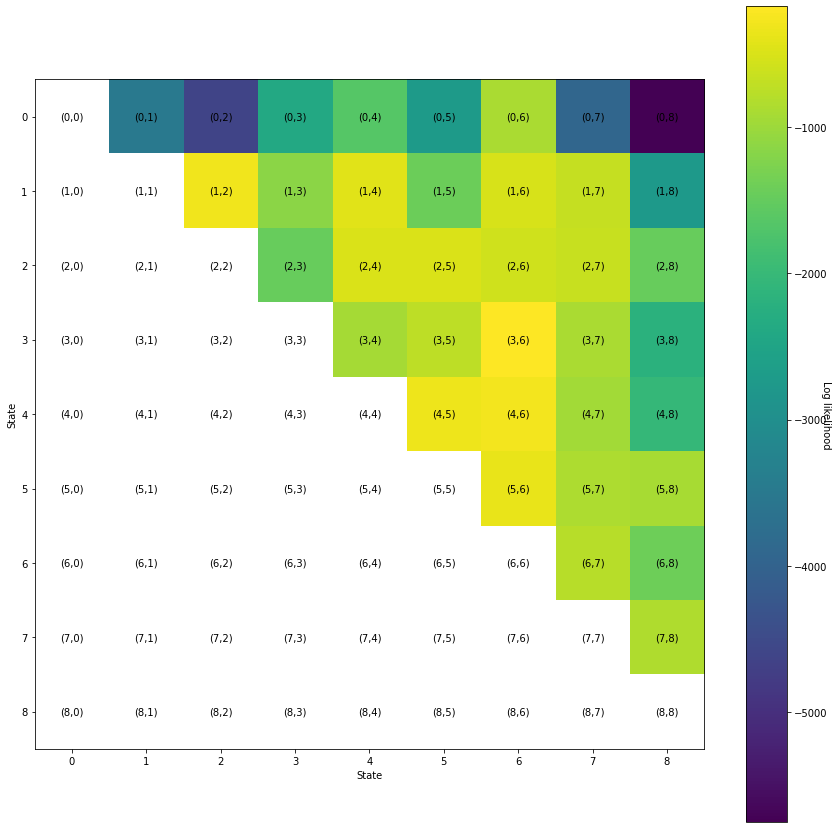

In [43]:
fig2 , ax = plt.subplots(1,1,figsize=(15,15))
similarity, new_hmms_3 = make_similarity_matrix(hmm_3, data_to_use)
#im = plt.imshow(similarity)
#plt.ylabel("state 1")
#plt.xlabel("state 2")
#plt.title("similarity")


im = ax.imshow(similarity)
cbar = fig2.colorbar(im,ax=ax)
#ax.set_title('Cross-Likelihoods')
ax.set_ylabel('State')
ax.set_xlabel('State')
cbar.ax.set_ylabel('Log likelihood', rotation=270)
for (j, i), _ in np.ndenumerate(similarity):
    label = '({},{})'.format(j, i)
    plt.text(i,j,label,ha='center',va='center')
#plt.show()
fig2.savefig("merge_after_2_2050_kappa2500.png")